# Universidad de los Andes
Departamento de Ingeniería Industrial

Maestría en Inteligencia Analítica para la Toma de Decisiones

#### Machine Learning

Estudiantes:

Integrante 1: Julián Felipe Baquero Mesa.

Integrante 2: Andrés Lozano.

Integrante 3: Lucila Evelys Noriega Fornaris.

### Usuario en Kaggle: Team A

# Project 2 - Movie Genre Classification
Classify a movie genre based on its plot.



https://www.kaggle.com/c/miia4200-20191-p2-moviegenreclassification/overview

Data
Input:

movie plot
Output: Probability of the movie belong to each genre

Evaluation
20% API
30% Create a solution using with a Machine Learning algorithm - Presentation
50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)
Acknowledgements
We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Descripición de los datos

In [24]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
import requests
import json
import time
import itertools
import os
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.externals import joblib

In [25]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [26]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [27]:
geners=dataTraining.genres

### Prueba 1
Se concatena la información del año, titulo y sinopsis de la película en una nueva columna llamada concatenada. Este proceso se realiza tanto para el dataTraining como el dataTesting. Utilizado para la construcción del API.

In [28]:
dataTraining['concatenada'] = dataTraining.apply(lambda x: " ".join([str(x[i]) for i in range(0,3)]),axis=1)

In [29]:
dataTraining.head()

,year,title,plot,genres,rating,concatenada
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,2003 Most most is the story of a single father...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,2008 How to Be a Serial Killer a serial killer...
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,"1941 A Woman's Face in sweden , a female blac..."
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,1954 Executive Suite in a friday afternoon in ...
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,"1990 Narrow Margin in los angeles , the edito..."


Ejemplo de la nueva columna en el dataTraining

In [30]:
dataTraining.iloc[0][5]

'2003 Most most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender .  a day before ,  the boy meets a woman boarding a train ,  a drug abuser .  at the bridge ,  the father goes into the engine room ,  and tells his son to stay at the edge of the nearby lake .  a ship comes ,  and the bridge is lifted .  though it is supposed to arrive an hour later ,  the train happens to arrive .  the son sees this ,  and tries to warn his father ,  who is not able to see this .  just as the oncoming train approaches ,  his son falls into the drawbridge gear works while attempting to lower the bridge ,  leaving the father with a horrific choice .  the father then lowers the bridge ,  the gears crushing the boy .  the people in the train are completely oblivious to the fact a boy died trying to save them ,  other than the drug addict woman ,  who happened to look out her train window .  the movie ends ,  with the

Creación de la columna concatenada para el dataTesting

In [31]:
dataTesting['concatenada']=dataTesting.apply(lambda x: " ".join([str(x[i]) for i in range(len(x))]),axis=1)

In [32]:
dataTesting.head()

,year,title,plot,concatenada
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ....","1999 Message in a Bottle who meets by fate , ..."
4,1978,Midnight Express,"the true story of billy hayes , an american c...",1978 Midnight Express the true story of billy ...
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...,1996 Primal Fear martin vail left the chicago ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...,1950 Crisis husband and wife americans dr . e...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...,1959 The Tingler the coroner and scientist dr ...


Ejemplo columna concatenada en el dataTesting

In [33]:
dataTesting.iloc[0][3]

"1999 Message in a Bottle who meets by fate ,  shall be sealed by fate .  theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore .  inside is a message ,  reading the letter she feels so moved and yet she felt as if she has violated someone ' s thoughts .  in love with a man she has never met ,  theresa tracks down the author of the letter to a small town in wilmington ,  two lovers with crossed paths .  but yet one can ' t let go of their past ."

Se realiza el análisis descriptivo de los datos contenidos en en dataTraining. Se analizan los valores pertenecientes a la columna genres.

In [34]:
cat_val = ["genres"]

for col in cat_val:
    print ([col]," : ",dataTraining[col].unique())

['genres']  :  ["['Short', 'Drama']" "['Comedy', 'Crime', 'Horror']"
 "['Drama', 'Film-Noir', 'Thriller']" ...
 "['Crime', 'Film-Noir', 'Romance', 'Thriller']"
 "['Adventure', 'Musical', 'Fantasy', 'Comedy', 'Romance']"
 "['Animation', 'Adventure', 'Drama', 'Family', 'Fantasy', 'Sci-Fi']"]


Con las variables numéricas (rating y año) se establece la matriz de dispersión.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B5A3FBEB38>,
      dtype=object)

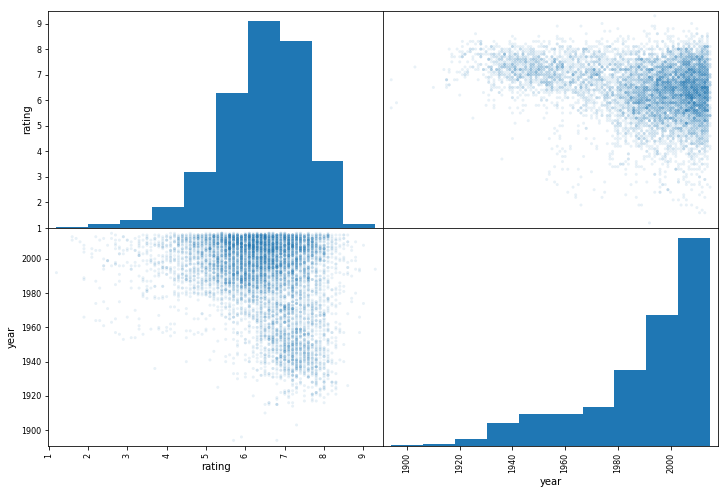

In [35]:
num_attributes = ["genres", "rating", "year"]
pd.plotting.scatter_matrix(dataTraining[num_attributes], figsize = (12,8), alpha = 0.1)

De los historgramas vemos que existe una distribución sesgada del raiting y de los años, lo cual es bueno ya que la inclusión de estas variables en el modelo traen consigo informacion acidicional sobre los generos, sin embargo como en testing no esta el raiting no es posible considerar esta información dentro del modelo, en simulaciones realizadas el año si aporta y ayuda a mejorar la precisión 

#### Histograma de las peliculas por año

C:\Users\ivivger1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


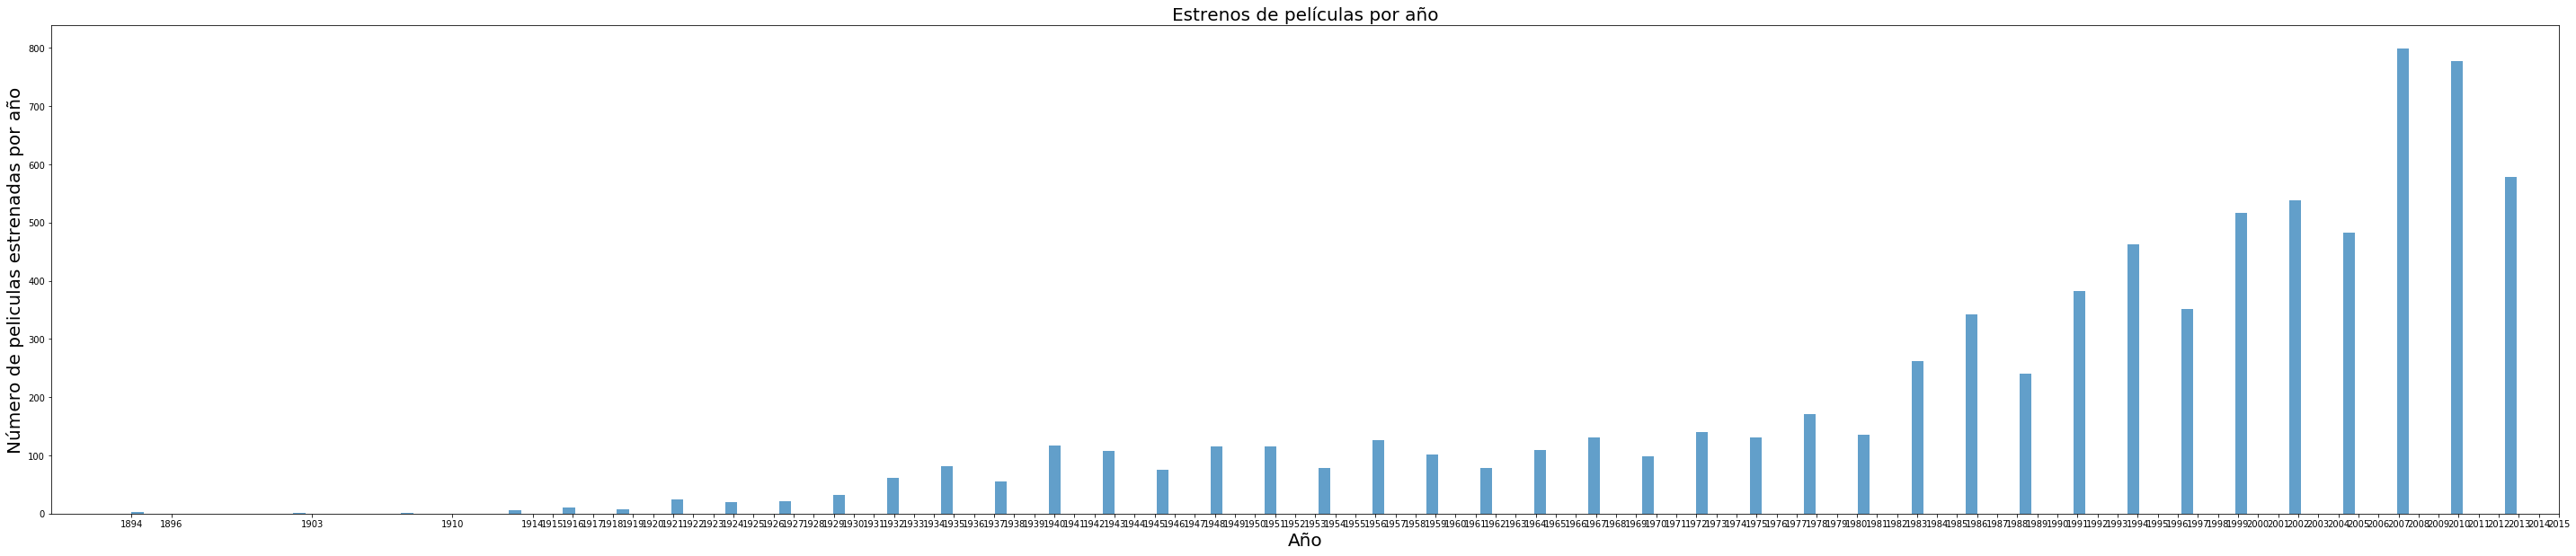

In [36]:
fig = plt.figure(figsize=(50,10))
ax = fig.gca()
sns.distplot(dataTraining.year,kde=False, hist_kws={"alpha":0.7,'width':0.6})
plt.title('Estrenos de películas por año',fontsize=20)
plt.xticks(sorted(dataTraining.year.unique()),horizontalalignment='center')
plt.ylabel('Número de peliculas estrenadas por año',fontsize=20)
plt.xlabel('Año', fontsize=20)
plt.xlim(1890,2015)
plt.show()

Visualmente se intuye que a industria cinematográfica ha tenido un crecimiento exponnecial, de acuerdo a la información contenida en los datos iniciales. Todo este análisis es realizado sobre el contenido de los datos de Training.

In [37]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

Teniendo en cuenta que hay películas clasificadas en varios géneros, se crea el un nuevo dataframe df2, donde cada uno de los diferentes géneros que tiene una película se separan en columnas. Todo esto con el fin de poder hacer un análisis gráfico.

In [38]:
df2 = pd.DataFrame(dataTraining['genres'].values.tolist(), index=dataTraining.index)
print(df2.head())

           0          1         2     3     4     5     6     7     8
3107   Short      Drama      None  None  None  None  None  None  None
900   Comedy      Crime    Horror  None  None  None  None  None  None
6724   Drama  Film-Noir  Thriller  None  None  None  None  None  None
4704   Drama       None      None  None  None  None  None  None  None
2582  Action      Crime  Thriller  None  None  None  None  None  None


Inicialmente, la variable categórica se convierte en numérica. Esto se hizo únicamente para la primera columna, que es la que tiene resultados más completos. La asignación numérica de las variables se hizo a partir de su orden alfabético. El parámetro sort e el que permite dicha asignación por orden alfabético. (24 géneros)

In [39]:
dataTraining['generos']=df2[0]
dataTraining['generos']=pd.factorize(dataTraining.generos,sort=True)[0]
print(dataTraining['generos'].head())

3107    18
900      4
6724     7
4704     7
2582     0
Name: generos, dtype: int64


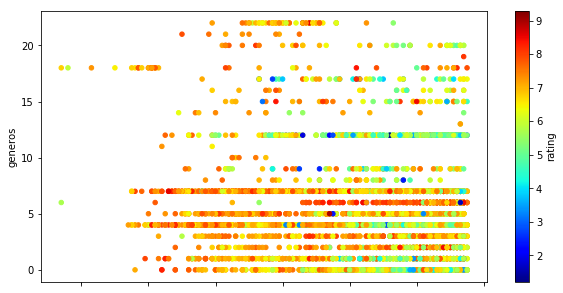

In [40]:
dataTraining.plot(kind='scatter', x='year', y='generos',c='rating', colormap='jet', figsize=(10,5))

De acuerdo a la gráfica anterior, las películas del género musical son la que presentan menor rating. Las películas clasificadas en los primero géneros: Acción, aventura y drama por nombrar algunas, son las presentan mayores índices de rating. adicionalmente vemos como algunos generos se caracterizan por tener en su mayoria rating similares

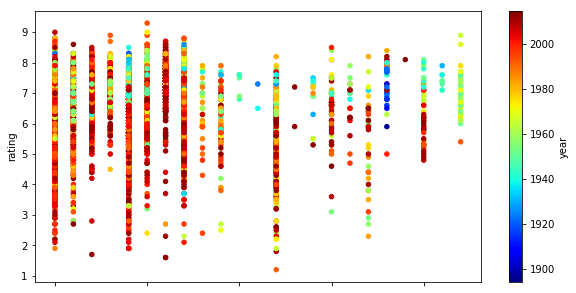

In [41]:
dataTraining.plot(kind='scatter', c='year', x='generos',y='rating', colormap='jet', figsize=(10,5))

Las películas del género oeste tuvieron su auge en los años 60's y 70's aproximadamente. En la década de los 40's y 50´s se desarrollaron las películas de guerra, como consecuencia del periodo post Segunda Guerra Mundial.

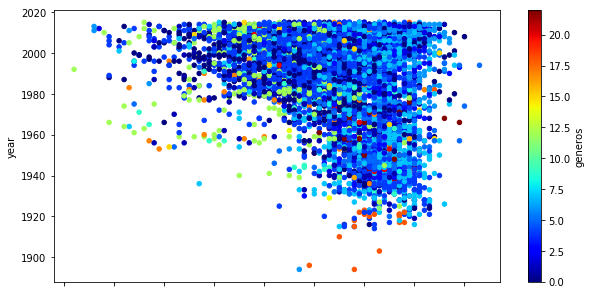

In [42]:
dataTraining.plot(kind='scatter', y='year', c='generos',x='rating', colormap='jet', figsize=(10,5))

La nube de puntos azules da cuenta de que la mayoría de las películas incluidas en los datos se dstribuyen aproximadamente entre los 10 primeros géneros categorizados. De igual manera se infiere, que el rating de las pelíclas ha aumenta con el paso de tiempo, teniendo en cuenta que han aparecido nuevas plataformas de desarrollo de la industria cinematográfica.

### Indicador de Importancia de las palabras por genero

Se contruye bajo un indice de correlación un listado de las palabras que aportan significativamente (mas de un 85%) en el genero, 
si la palabra esta presente en la sinopsis, primero se seleccionaran las palabras con una frecuencia mayor a un umbral, luego se 
realizará tablas cruzadas para evaluar la relación entre el genero y cada palabra de acuerdo al numero de casos exitosos de 
clasificación, con estas palabras tendremos el listado de palabras que luego usaremos para enriquecer el texto, inyectando estas 
palabras claves.

In [43]:
# Term Frequency
vect = CountVectorizer()
dfgeners = pd.DataFrame(vect.fit_transform(geners).toarray(), columns=vect.get_feature_names())
dfgeners.head(5)

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,mystery,news,noir,romance,sci,short,sport,thriller,war,western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
dfgeners.columns

Index(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fi', 'film', 'history',
       'horror', 'music', 'musical', 'mystery', 'news', 'noir', 'romance',
       'sci', 'short', 'sport', 'thriller', 'war', 'western'],
      dtype='object')

In [45]:
dfgeners.rename(columns={'action':'g_action', 'adventure':'g_adventure', 'animation':'g_animation', 'biography':'g_biography',
                         'comedy':'g_comedy', 'crime':'g_crime','documentary':'g_documentary', 'drama':'g_drama',
                         'family':'g_family', 'fantasy':'g_fantasy', 'fi':'g_fi', 'film':'g_film', 'history':'g_history',
                         'horror':'g_horror', 'music':'g_music', 'musical':'g_musical', 'mystery':'g_mystery', 'news':'g_news',
                         'noir':'g_noir',     'romance':'g_romance', 'sci':'g_sci', 'short':'g_short', 'sport':'g_sport',
                         'thriller':'g_thriller', 'war':'g_war', 'western':'g_western'},inplace=True)
dfgeners.columns

Index(['g_action', 'g_adventure', 'g_animation', 'g_biography', 'g_comedy',
       'g_crime', 'g_documentary', 'g_drama', 'g_family', 'g_fantasy', 'g_fi',
       'g_film', 'g_history', 'g_horror', 'g_music', 'g_musical', 'g_mystery',
       'g_news', 'g_noir', 'g_romance', 'g_sci', 'g_short', 'g_sport',
       'g_thriller', 'g_war', 'g_western'],
      dtype='object')

In [46]:
# Term Frequency
vect_key = CountVectorizer(stop_words='english',binary=True,max_df=0.7,min_df=3)
WordsText = pd.DataFrame(vect_key.fit_transform(dataTraining['plot']).toarray(), columns=vect_key.get_feature_names())
WordsText.head(5)

,aa,aaron,abandon,abandoned,abandoning,abandons,abbey,abbie,abbott,abby,...,zeus,zod,zoe,zoey,zombie,zombies,zone,zoo,zoom,zorro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
Listwords = pd.DataFrame([[key, vect_key.vocabulary_[key]] for key in vect_key.vocabulary_.keys()], columns=['Name', 'Frec'])
Listwords=Listwords[Listwords.Frec>13000]
# Listwords=Listwords.Name
Listwords = Listwords["Name"].tolist()
Listwords=set(Listwords)
print(Listwords)

{'suicide', 'styled', 'tract', 'spiral', 'wannabes', 'theories', 'squirrel', 'youth', 'spirits', 'transported', 'willy', 'weave', 'spate', 'violin', 'winstead', 'wright', 'willful', 'unofficially', 'tick', 'techniques', 'unsinkable', 'voldemort', 'suing', 'teddy', 'summit', 'swamp', 'wiped', 'staring', 'valiant', 'winnie', 'venture', 'timing', 'traces', 'sunshine', 'twins', 'stir', 'terrific', 'terminal', 'spice', 'tiffany', 'ticket', 'worried', 'ted', 'terrorized', 'vicariously', 'thesis', 'thorin', 'wedge', 'swing', 'uptight', 'sponsor', 'tyranny', 'zapped', 'willie', 'visitors', 'vortex', 'stunned', 'whereabouts', 'theaters', 'sponsored', 'touring', 'wines', 'tens', 'tendencies', 'swaps', 'turmoil', 'wonderful', 'swindling', 'turkish', 'stoddard', 'spooner', 'worldly', 'throw', 'victor', 'troops', 'tend', 'undead', 'water', 'towering', 'torn', 'zeke', 'syd', 'webb', 'surroundings', 'wealthiest', 'wand', 'transmits', 'squandered', 'vacations', 'stuff', 'teachings', 'witnesses', 'will

In [48]:
len(Listwords)

2500

In [49]:
# Term Frequency
vect = CountVectorizer(stop_words='english',binary=True, vocabulary=Listwords)
WordsText = pd.DataFrame(vect.fit_transform(dataTraining['plot']).toarray(), columns=vect.get_feature_names())
WordsText.head(5)

,soundtrack,soup,souped,sour,source,sources,sous,south,southeast,southern,...,zeus,zod,zoe,zoey,zombie,zombies,zone,zoo,zoom,zorro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
Words=set(WordsText.columns)
len(Words)

2500

In [51]:
Keywords=[]
Keywords_table=[]
for word in WordsText.columns:
    Text=WordsText[word]
#     print('Palabra de analisis.........' + word)
    for gen in dfgeners.columns:
        Genero=dfgeners[gen]
#         print('Genero de analisis.........' + gen)  
        # Tabla de contingencia class / survived
        table=pd.crosstab(index=dfgeners[gen],columns=WordsText[word], margins=True,)
        rela=table.iloc[1,1]/table.iloc[2,1]
#         print('Proporcion', + rela)
        if rela>0.85: 
#             print(table)
            print(word)
#             print(gen)
            Keywords.append(word)
            Keywords_table.append([word,gen,rela])
#             break
print(Keywords_table)

southeast
southside
sox
spacecraft
spacecraft
spaceship
spaceship
spaniards
spaniards
spares
spares
sparked
specialists
speechless
spelling
spender
sperm
spinster
spiritualist
spoof
sprawling
springer
spur
squadron
squadron
squire
squirrel
stacks
stagecoach
stakeout
stale
stalker
starfleet
starfleet
starfleet
starfleet
starship
steamer
steamer
stefan
stemming
steph
stepsisters
stepsisters
stereo
stereotypes
sterile
sting
stingy
stir
stoners
stooge
stowed
strangled
strangled
strategist
stratford
stratford
strengthened
strengthens
stresses
strippers
strode
stu
stud
stunningly
stunts
stupid
stupor
styled
stylist
sua
succubus
succumbing
succumbing
suffocating
suing
suited
superiority
supervising
supporter
supporting
suppose
suppressed
surete
surete
surgeons
surgical
susanna
susie
suspended
suspiciously
sustain
swears
swede
swede
sweden
swift
swimmer
swordsman
sylvester
synagogue
syndicate
syndrome
séance
séance
taboo
taboos
tackleberry
tactical
taggart
taker
talkative
tammy
tart
tastes
tat

In [52]:
Keywords_df=pd.DataFrame(Keywords_table,columns=('Palabra','Genero','Relacion'))
Keywords_df['Palabras']=pd.factorize(Keywords_df.Palabra,sort=True)[0]
Keywords_df['Generos']=pd.factorize(Keywords_df.Genero,sort=True)[0]

In [53]:
Keywords_df.head(10)

,Palabra,Genero,Relacion,Palabras,Generos
0,southeast,g_drama,1.0,0,6
1,southside,g_drama,1.0,1,6
2,sox,g_sport,1.0,2,15
3,spacecraft,g_fi,1.0,3,9
4,spacecraft,g_sci,1.0,3,14
5,spaceship,g_fi,1.0,4,9
6,spaceship,g_sci,1.0,4,14
7,spaniards,g_action,1.0,5,0
8,spaniards,g_adventure,1.0,5,1
9,spares,g_action,1.0,6,0


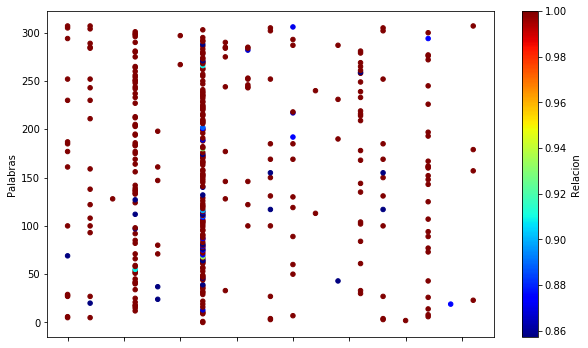

In [54]:
Keywords_df.plot(kind='scatter', x='Generos', y='Palabras',c='Relacion', colormap='jet', figsize=(10,6))

En el eje X encontramos los generos, como se puede apreciar existen donde encontramos mas palabras relacionadas con su
clasificacion, pero esta relación se puede dar mas por el desbalanceo de los datos.

C:\Users\ivivger1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ivivger1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


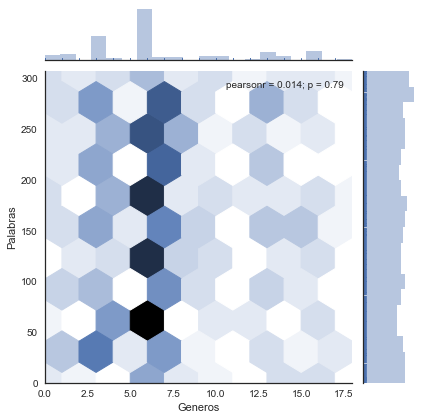

In [55]:
import seaborn as sns

# Custom the color
sns.set(style="white", color_codes=True)

# Custom the histogram and add rug:
sns.jointplot(x=Keywords_df["Generos"], y=Keywords_df["Palabras"], kind='hex', marginal_kws=dict(bins=20, rug=True))

al relacionar las palabra claves y los generos, apreciamos en las marginales como los generos tienen una distribución asimetrica
y con un apuntamiento que sugiere que hay un grupo de palabras claves que aportan información valiosa sobre la clasificación de 
los generos. 

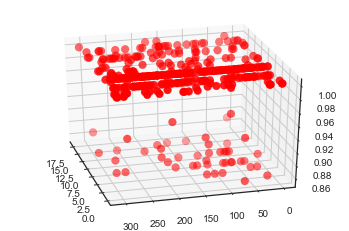

In [56]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
  
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Keywords_df['Generos'], Keywords_df['Palabras'], Keywords_df['Relacion'], c='red', s=60)
ax.view_init(30, 165)
plt.show()

Cuando incluimos una tercer dimension, apreciamos que dentro de las palabras seleccionadas, existen algunas que con seguridad
nos indican el genero, tal como "spaceship" que se asocia 100% a peliculas de ciencia ficcion. en la modelación realizada
encontramos que este grupo de palabras nos dan aproximadamente 1 punto incremental de precisión

In [57]:
Keywords=set(Keywords)

In [58]:
len(Keywords)

308

## Creación del Y
multiLabelBinarizer genera un vector con todos los géneros, y pone uno en el género que se presenta para esa pelicula

In [17]:
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [18]:
le.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

### Create count vectorizer


In [19]:
def tokenize_test(vect):
    X_vec = vect.fit_transform(dataTraining['concatenada'])
    print('Features: ', X_vec.shape)
    return X_vec

Se llaman nuevas librerías para poder utilizar los lemmas.

In [20]:
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    #print(words)
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [22]:
vect = TfidfVectorizer(max_df=0.4,ngram_range=(1, 2),analyzer=split_into_lemmas)
X_vec=tokenize_test(vect)

Features:  (7895, 36462)


Con la función joblib se guarda la parametrización de vect que será utilizada en la construcción del API. Lo guarda en un .pkl. 

In [23]:
joblib.dump(vect,'C:/Users/Usuario/Documents/machineLearning/Proyecto/ProyectoDos/movieLemmaCompleto_vect.pkl', compress=3)

['C:/Users/Usuario/Documents/machineLearning/Proyecto/ProyectoDos/movieLemmaCompleto_vect.pkl']

Algunas características de vect teniendo en cuenta que la instrucción anterior no incluia stopwords. Por defecto, la función arroja las siguientes, que corresponde en su mayoría a preposiciones, signos de puntuación y pronombres.

In [24]:
vect.stop_words_

{"'",
 ',',
 '-',
 '.',
 'a',
 'an',
 'and',
 'but',
 'by',
 'for',
 'ha',
 'he',
 'his',
 'in',
 'is',
 'of',
 'on',
 's',
 'that',
 'the',
 'to',
 'when',
 'who',
 'with'}

Con la función vect.vocabulary se cuenta la frecuencia con la que aparecen determinadas palabras a lo largo de toda la data.

In [25]:
vect.vocabulary_

{'2003': 170,
 'most': 21770,
 'story': 31133,
 'single': 29696,
 'father': 11768,
 'take': 31990,
 'eight': 10321,
 'year': 36146,
 'old': 23127,
 'son': 30276,
 'work': 35939,
 'him': 15193,
 'at': 2047,
 'railroad': 26222,
 'drawbridge': 9812,
 'where': 35515,
 'bridge': 4231,
 'tender': 32300,
 'day': 8131,
 'before': 2995,
 'boy': 4025,
 'meet': 20803,
 'woman': 35874,
 'boarding': 3701,
 'train': 33125,
 'drug': 9907,
 'abuser': 384,
 'go': 13608,
 'into': 16802,
 'engine': 10721,
 'room': 27869,
 'tell': 32260,
 'stay': 30907,
 'edge': 10238,
 'nearby': 22303,
 'lake': 18425,
 'ship': 29379,
 'come': 6456,
 'lifted': 19040,
 'though': 32591,
 'it': 17021,
 'supposed': 31616,
 'arrive': 1840,
 'hour': 15585,
 'later': 18585,
 'happens': 14543,
 'see': 28897,
 'this': 32554,
 'try': 33474,
 'warn': 35202,
 'not': 22763,
 'able': 321,
 'just': 17593,
 'oncoming': 23185,
 'approach': 1638,
 'fall': 11615,
 'gear': 13231,
 'while': 35530,
 'attempting': 2104,
 'lower': 19525,
 'leavi

Separación de los datos del Training para Training y Test

In [26]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_vec, y_genres, test_size=0.5, random_state=42)

### Train multi-class multi-label model

El OneVsRestClassifier consiste en entrenar un clasificador por cada clase. En cada clasificador la clase es comparada contra todas las clases.

In [27]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=1200, max_depth=150,random_state=6000000, max_features='sqrt',min_samples_leaf=5,min_samples_split=5))


In [28]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
          n_jobs=None)

Generación del .pkl del Random Forest que se usará en el API.

In [29]:
joblib.dump(clf,'C:/Users/Usuario/Documents/machineLearning/Proyecto/ProyectoDos/movieLemmaCompleto_clf.pkl', compress=3)

['C:/Users/Usuario/Documents/machineLearning/Proyecto/ProyectoDos/movieLemmaCompleto_clf.pkl']

In [30]:
y_pred_genres = clf.predict_proba(X_test)

In [31]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8409760830793651

### Prueba 2: Búsqueda de los parámetros evaluando cada uno por separado

Lista de valores para encontrar el número de estimadores

In [39]:
estimator_range = range(10, 600, 50)
accuracy_scores = []

for estimator in estimator_range:
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=estimator,random_state=42))
    clf.fit(X_train, y_train_genres)
    y_pred_genres = clf.predict_proba(X_test)
    accuracy_scores.append(roc_auc_score(y_test_genres, y_pred_genres, average='macro').mean()) 

Text(0, 0.5, 'Accuracy')

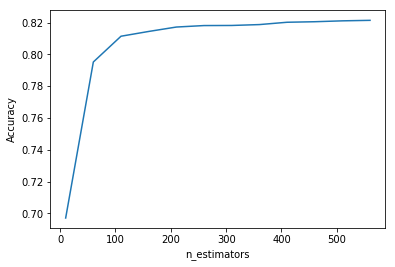

In [40]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [41]:
for i in range(len(accuracy_scores)):
    print(estimator_range[i],':', accuracy_scores[i])
    print(i)

10 : 0.6970277511635695
0
60 : 0.7952224085325632
1
110 : 0.8114391122276198
2
160 : 0.8144408333290399
3
210 : 0.8172188941852948
4
260 : 0.8181483735998598
5
310 : 0.8182102419949032
6
360 : 0.818765566631725
7
410 : 0.8202268101629687
8
460 : 0.8205631550779309
9
510 : 0.8211214237004828
10
560 : 0.8214379723150188
11


Lista de valores para encontrar la máxima profundidad

In [42]:
depth_range = range(1, 100, 10)
accuracy_scores = []

for depth in depth_range:
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=360, max_depth=depth,random_state=42))
    clf.fit(X_train, y_train_genres)
    y_pred_genres = clf.predict_proba(X_test)
    accuracy_scores.append(roc_auc_score(y_test_genres, y_pred_genres, average='macro').mean()) 

Text(0, 0.5, 'Accuracy')

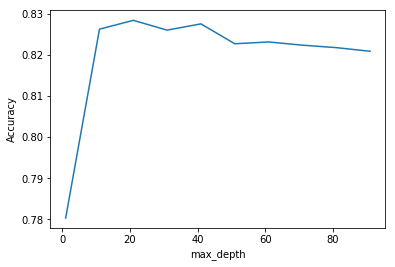

In [43]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [44]:
print(accuracy_scores)

[0.7803192267088193, 0.8263217645053684, 0.8284710282447415, 0.8260879175676376, 0.827612020856224, 0.8227653540226871, 0.8232029727182976, 0.8224236461068647, 0.8218233550833774, 0.8209341260229447]


Lista de valores para encontrar el número de feature

In [45]:
feature_range = range(1, X_train.shape[1]+1)
accuracy_scores = []


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executo

KeyboardInterrupt: 

### Predict the testing dataset

In [32]:
X_test_dtm = vect.transform(dataTesting['plot'],dataTesting['title'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)


In [33]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [34]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.145743,0.089379,0.038586,0.046727,0.434324,0.181893,0.048680,0.542461,0.078918,0.132399,...,0.063843,0.115149,0.000946,0.380696,0.073212,0.015853,0.030668,0.234115,0.046439,0.022427
4,0.151598,0.067050,0.034072,0.061306,0.329251,0.265573,0.087852,0.585104,0.052054,0.053906,...,0.020154,0.034934,0.001841,0.126049,0.029045,0.026377,0.021946,0.153034,0.066453,0.024760
5,0.143749,0.055512,0.007511,0.028785,0.256427,0.406754,0.022783,0.613884,0.036312,0.038851,...,0.021042,0.212924,0.000091,0.224236,0.047758,0.001290,0.019640,0.388191,0.046694,0.015782
6,0.180040,0.131674,0.017810,0.051281,0.316694,0.163158,0.043650,0.591665,0.061782,0.092857,...,0.056057,0.139033,0.000077,0.299325,0.164717,0.010423,0.037281,0.353738,0.096279,0.035791
7,0.135479,0.131022,0.015115,0.044097,0.280537,0.186694,0.044929,0.418048,0.068691,0.111142,...,0.020228,0.127588,0.000013,0.194646,0.277084,0.005146,0.019806,0.266508,0.021796,0.015502


In [35]:
res.to_csv('pred_genres_text_RF7.csv', index_label='ID')
#Esto nos permite descargar el archivo en formato CSV en Google
#from google.colab import files
#files.download("pred_genres_text_RF.csv")

# Código para el API

## Código de api.py

Definición de la función split into lemas para tokenizar la información que se digita en el API.

In [36]:
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

#Se define la función que permite usar lemmatizer para poner las palabras en su forma básica
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    #print(words)
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Simulación de los campos a digitar en el API

In [37]:
year=1999
title='Message in a Bottle'
plot='who meets by fate ,  shall be sealed by fate .  theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore .  inside is a message ,  reading the letter she feels so moved and yet she felt as if she has violated someone  s thoughts .  in love with a man she has never met ,  theresa tracks down the author of the letter to a small town in wilmington ,  two lovers with crossed paths .  but yet one can  t let go of their past .'

## Código de model_movie.py

In [38]:
#Toma la información digitada y la agrega en un array, para después crear un dataFrame
datos=[year, title, plot]
data_ = pd.DataFrame([datos], columns=['Year','Title','Plot'])

#Carga los .pkl de los modelos de predicción y de vectorizer
__file__='C:/Users/Usuario/Documents/machineLearning/Proyecto/ProyectoDos/'
clf = joblib.load(os.path.dirname(__file__) + '/movieLemma_clf.pkl')
vect = joblib.load(os.path.dirname(__file__) + '/movieLemma_vect.pkl')

#Imprime la información en el terminal de lo que se digitó
print('La información es:','\n', data_.iloc[0],'\n')

#Crea una nueva columna llamada 'concatenada' que agrupa los datos de año, titulo y resumen de la pelicula
data_['concatenada']=data_.apply(lambda x: " ".join([str(x[i]) for i in range(len(x))]),axis=1)

#Se aplica el vectorizer a la información. Esta función necesita la función split_into_lemmas
X_test_dtm = vect.transform(data_['concatenada'])

#Imprime el tamaño del X_test después de aplicarle el Vectorizer
print('El tamaño del X_test es: ',X_test_dtm.shape,'\n')

#Realiza la predicción de la información digitada a partir del modelo generado y cargado en clf
y_pred_test_genres = clf.predict_proba(X_test_dtm)

#Genera el nombre de las columnas para el dataFrame de la predicción con la probabilidad de acuerdo al géneo
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
#Creación del dataFrame con las predicciones de los géneros
res1 = pd.DataFrame(y_pred_test_genres, columns=cols)

#Imprime en el terminal la probabilidad por género
print('La probabilidad por género es: ','\n',res1.transpose())

La información es: 
 Year                                                  1999
Title                                  Message in a Bottle
Plot     who meets by fate ,  shall be sealed by fate ....
Name: 0, dtype: object 

El tamaño del X_test es:  (1, 36462) 

La probabilidad por género es:  
                   0
p_Action       0.18
p_Adventure    0.11
p_Animation    0.00
p_Biography    0.05
p_Comedy       0.30
p_Crime        0.14
p_Documentary  0.00
p_Drama        0.56
p_Family       0.03
p_Fantasy      0.09
p_Film-Noir    0.02
p_History      0.01
p_Horror       0.04
p_Music        0.00
p_Musical      0.04
p_Mystery      0.10
p_News         0.00
p_Romance      0.46
p_Sci-Fi       0.06
p_Short        0.03
p_Sport        0.01
p_Thriller     0.25
p_War          0.02
p_Western      0.00


Dirección del API
http://13.59.186.170:8888/

Información para el ejemplo:

year=1999

title='Message in a Bottle'

plot='who meets by fate ,  shall be sealed by fate .  theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore .  inside is a message ,  reading the letter she feels so moved and yet she felt as if she has violated someone  s thoughts .  in love with a man she has never met ,  theresa tracks down the author of the letter to a small town in wilmington ,  two lovers with crossed paths .  but yet one can  t let go of their past .


